In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient


import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

## For analysis, we'll begin by importing all of our data from MongoDb

In [2]:
client = MongoClient()
db_nba= client.nba


collection_p = db_nba.player_stats
df_nba = pd.DataFrame(list(collection_p.find()))

collection_t = db_nba.team_stats
df_team = pd.DataFrame(list(collection_t.find()))

collection_r = db_nba.team_rosters
df_r = pd.DataFrame(list(collection_r.find()))

Let's take a high-level look at our player stats dataframe.

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13168 entries, 0 to 13167
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                13168 non-null  object 
 1   Player_ID          13168 non-null  int64  
 2   GROUP_VALUE        13168 non-null  object 
 3   TEAM_ID            13168 non-null  int64  
 4   TEAM_ABBREVIATION  13168 non-null  object 
 5   GP                 13168 non-null  int64  
 6   W                  13168 non-null  int64  
 7   L                  13168 non-null  int64  
 8   FGM                13168 non-null  int64  
 9   FGA                13168 non-null  int64  
 10  FG_PCT             13168 non-null  float64
 11  FG3M               13168 non-null  int64  
 12  FG3A               13168 non-null  int64  
 13  FG3_PCT            13168 non-null  float64
 14  FTM                13168 non-null  int64  
 15  FTA                13168 non-null  int64  
 16  FT_PCT             131

## Looks like we can clean this up a bit. 

First, we don't need the '_id' column, as this is a Mongo convention to identify individual entries.
Second, we can rename the 'GROUP_VALUE' column to 'season', based on our knowledge of that column in builder the scrapers.
Lastly, let's convert all column names to lowercase for ease of indexing.

In [4]:
df_nba.drop(columns=['_id'], inplace = True)
df_nba.rename(columns={'GROUP_VALUE':'season'}, inplace = True)

In [5]:
d_lower = dict()
for i in df_nba.columns:
    d_lower[i] = i.lower()

df_nba.rename(columns=d_lower, inplace = True)
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [6]:
# Check scraper progress

max_id = np.max(df_nba['player_id'])

In [7]:
df_nba.loc[df_nba['player_id']==max_id]

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,reb,ast,tov,stl,blk,blka,pf,pfd,pts,plus_minus
13167,1629541,2018-19,1610612740,NOP,12,3,9,12,47,0.255,...,9,10,2,1,0,2,7,7,34,-50


The last bit of preliminary cleaning will be to get rid of all entries for the 2019-20 season, as the season was stalled, so we won't have any target values. We can do this via indexing.

In [8]:
df_nba.drop(df_nba[df_nba['season'] == '2019-20'].index , inplace=True)

# We first want to investigate the predictivity of regular season wins based on a team roster's individual efficiency ratings from the prior year. 

There are a handful of efficiency metrics that are worth invesitgating here:

Martin Manley's Efficiency ('EFF') = ((Points + Rebounds + Assists + Steals + Blocks) - (Missed Field Goals + Missed Free Throws + Turnovers))/ Games Played

European Performance Index Rating ('PIR') = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed))/ Games Played

Plus-Minus Avg('+/-') = Seasonal plus-minus / Games Played : This describes the point differential for each game with a player on the floor without keeping track of more specific individual metrics. I.e., how does the score spread change when a player is in the game?

Note: We will not be considering John Hollinger's Player Efficiency Rating ('PER'): It is the most frequently used alternative, however PER is derived by a very complex calculation designed to compensate for different teams' varying style of play, among other factors, and PER scores do not differ markedly from EFF scores.

This study is more so interested in an individual player's efficiency being predictive of team success, regardless of coaching and playing styles. Furthermore, looking at these raw statistics will help inform to what extent a coach should seek to opitimize all individual player efficiencies, or spend a majority of their time tending to star players, or perhaps optimizing other metrics via playing style.

# Let's calculate EFF, PIR, and +/- for each player on a per season basis. Then we'll aggregate team rosters on a yearly basis, to eventually offset one season's stats to be fit to the following season's results.

In [9]:
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [10]:
"""EFF = ((Points + Rebounds + Assists + Steals + Blocks) - Missed Field Goals - Missed Free Throws - Turnovers))/ Games Played"""

df_nba['eff'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov']) / df_nba['gp']


"""PIR = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - Missed Field Goals - Missed Free Throws - Turnovers - Shots Rejected - Fouls Committed))/ Games Played"""
df_nba['pir'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']+df_nba['pfd']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov'] \
                 - df_nba['blka'] \
                 - df_nba['pf']) / df_nba['gp']
df_nba['+/-'] = df_nba['plus_minus'] / df_nba['gp']

## Below are the results of our EFF, PIR, and +/- calculations.

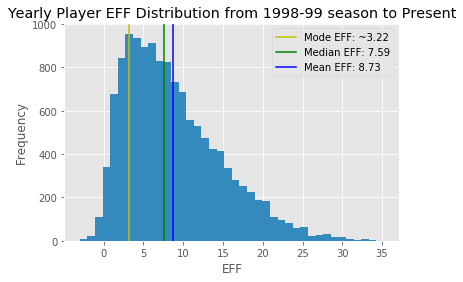

In [11]:
#Calculate all EFF averages and plot histogram to inform distribution

mean_eff = round(np.mean(df_nba['eff']),2)
median_eff = round(np.median(df_nba['eff']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['eff'], bins = 40)
ax.set_title('Yearly Player EFF Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['eff'], bins = 40)[0],ax.hist(df_nba['eff'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_eff = round(np.mean([upper,lower]),2)

ax.axvline(mode_eff, color = 'y', label = f'Mode EFF: ~{mode_eff}')
ax.axvline(median_eff, color = 'g', label = f'Median EFF: {median_eff}')
ax.axvline(mean_eff, color = 'b', label = f'Mean EFF: {mean_eff}')

ax.set_ylabel('Frequency')
ax.set_xlabel('EFF')
ax.legend()


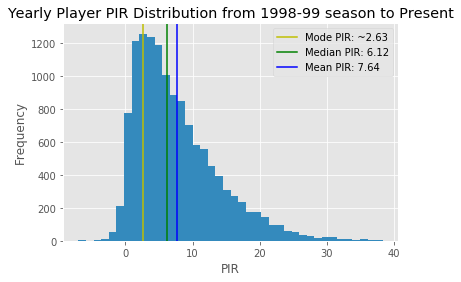

In [12]:
#Calculate all PIR averages and plot histogram to inform distribution

mean_pir = round(np.mean(df_nba['pir']), 2)
median_pir = round(np.median(df_nba['pir']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['pir'], bins = 40)
ax.set_title('Yearly Player PIR Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['pir'], bins = 40)[0],ax.hist(df_nba['pir'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_pir = round(np.mean([upper,lower]),2)

ax.axvline(mode_pir, color = 'y', label = f'Mode PIR: ~{mode_pir}')
ax.axvline(median_pir, color = 'g', label = f'Median PIR: {median_pir}')
ax.axvline(mean_pir, color = 'b', label = f'Mean PIR: {mean_pir}')

ax.set_ylabel('Frequency')
ax.set_xlabel('PIR')
ax.legend()


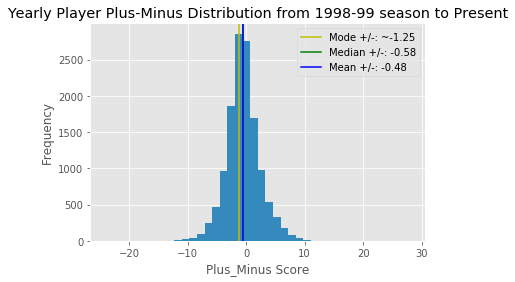

In [13]:
#Calculate all +/- averages and plot histogram to inform distribution

mean_pm = round(np.mean(df_nba['+/-']),2)
median_pm = round(np.median(df_nba['+/-']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['eff'], bins = 40)
ax.set_title('Yearly Player Plus-Minus Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['+/-'], bins = 40)[0],ax.hist(df_nba['+/-'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_pm = round(np.mean([upper,lower]),2)

ax.axvline(mode_pm, color = 'y', label = f'Mode +/-: ~{mode_pm}')
ax.axvline(median_pm, color = 'g', label = f'Median +/-: {median_pm}')
ax.axvline(mean_pm, color = 'b', label = f'Mean +/-: {mean_pm}')

ax.set_ylabel('Frequency')
ax.set_xlabel('Plus_Minus Score')
ax.legend()

## Now let's group the player data by player_id and season, so that we can pull the statistic values from a prior year, and use those as features for a team based on roster. 

First, we'll group the dataframe by players and season. We do this instead of grouping by teams and season, to allow for us to account for roster changes season over season.

We can then reference player_id values for the target season to ensure we're selecting the right features (i.e, player statistics from the previous year, regardless of team affiliation). 

In [14]:
# First we'll group just by player so we can check if a particular season is relevant to them. 

df_by_player = df_nba.groupby(['player_id'])
df_by_player.get_group((max_id))


,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,stl,blk,blka,pf,pfd,pts,plus_minus,eff,pir,+/-
13167,1629541,2018-19,1610612740,NOP,12,3,9,12,47,0.255,...,1,0,2,7,7,34,-50,1.416667,1.25,-4.166667


In [15]:
# Here we group by both player and season so that we can pull particular efficiency scores per player per year.

df_by_p_s = df_nba.groupby(['player_id','season'])

df_by_p_s.get_group((max_id,'2018-19'))

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,stl,blk,blka,pf,pfd,pts,plus_minus,eff,pir,+/-
13167,1629541,2018-19,1610612740,NOP,12,3,9,12,47,0.255,...,1,0,2,7,7,34,-50,1.416667,1.25,-4.166667


In [16]:
df_nba.loc[df_nba['+/-'] == 0]

,player_id,season,team_id,team_abbreviation,gp,w,l,fgm,fga,fg_pct,...,stl,blk,blka,pf,pfd,pts,plus_minus,eff,pir,+/-
177,87,2008-09,1610612745,HOU,9,6,3,5,13,0.385,...,0,11,1,11,10,16,0,4.777778,4.555556,0.0
233,100,1997-98,1610612764,WAS,8,4,4,3,19,0.158,...,1,0,2,11,0,9,0,-0.500000,-2.125000,0.0
749,292,2000-01,1610612745,HOU,1,0,1,0,0,0.000,...,0,0,0,1,0,0,0,0.000000,-1.000000,0.0
885,359,2000-01,1610612744,GSW,6,2,4,9,20,0.450,...,3,1,0,10,0,24,0,5.666667,4.000000,0.0
1207,462,1998-99,1610612747,LAL,25,12,13,44,108,0.407,...,15,0,5,72,0,126,0,6.440000,3.360000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,1627863,2016-17,1610612764,WAS,1,0,1,0,0,0.000,...,0,0,0,0,0,0,0,1.000000,1.000000,0.0
12952,1628393,2018-19,1610612760,OKC,1,1,0,0,1,0.000,...,0,0,0,0,0,0,0,-1.000000,-1.000000,0.0
12974,1628404,2018-19,1610612747,LAL,67,31,36,189,464,0.407,...,64,40,31,147,87,525,0,9.134328,7.776119,0.0
13136,1629093,2018-19,1610612760,OKC,1,1,0,0,1,0.000,...,0,0,0,0,0,0,0,0.000000,0.000000,0.0


## Now, we can iterate through team rosters by season to pull the prior year's efficiency metrics per player. 

Investigate roster dataframe to determine how to properly pull ['eff'] from player dataframe.

In [17]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     630 non-null    object
 1   team    630 non-null    int64 
 2   season  630 non-null    object
 3   roster  630 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.8+ KB


Again, we can drop the '_id' column, as this is just a mongo convention

In [18]:
df_r.drop(columns = ['_id'], inplace = True)

In [19]:
df_r.head()

,team,season,roster
0,1610612737,1998-99,"[673, 1533, 1544, 87, 1516, 3, 1852, 111, 770,..."
1,1610612738,1998-99,"[692, 952, 1477, 1800, 344, 368, 35, 65, 72, 1..."
2,1610612739,1998-99,"[692, 226, 682, 1510, 1538, 916, 198, 1507, 18..."
3,1610612740,1998-99,[]
4,1610612741,1998-99,"[457, 82, 699, 1869, 1736, 1757, 54, 1522, 160..."


## It will be worthwhile to examine the sizes of the rosters so that we can encompass to see if there's any relationship between that and a team's success. 

In [20]:
df_r['len_roster'] = [len(r) for r in df_r['roster'].to_numpy()]

In [21]:
max_r = df_r['len_roster'][np.argmax(df_r['len_roster'])]
df_r.loc[df_r['len_roster']==max_r]

,team,season,roster,len_roster
536,1610612763,2015-16,"[1627293, 2757, 201148, 1627362, 203955, 2365,...",28
626,1610612763,2018-19,"[1626150, 202340, 203998, 101139, 202718, 2034...",28


### It's unlikely that the efficiency scores for all 28 people on this particular roster will be noteworthy features. Furthermore, only 17 players are allowed to be on the active roster for an NBA team.

## For sake of indexing, we need to get all unique team IDs and seasons into two separate arrays.

We'll then group the roster dataframe by team and season, and use Pandas' get_group() method to pull the roster for a given season. We'll then iterate through the roster to select player efficiency scores from the prior year in the df_by_player dataframe via player_id and season. 

In [22]:
teams = np.unique(df_team['TeamID'])
seasons = np.unique(df_nba['season'])

teams,seasons

(array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
        1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
        1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
        1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
        1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
        1610612762, 1610612763, 1610612764, 1610612765, 1610612766]),
 array(['1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
        '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
        '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
        '2015-16', '2016-17', '2017-18', '2018-19'], dtype=object))

## Group roster dataframe by team_id and season

In [23]:
df_r = df_r.groupby(['team','season'])


In [24]:
roster = df_r.get_group((1610612737,'1998-99'))['roster']
for r in roster:
    print(r)

[673, 1533, 1544, 87, 1516, 3, 1852, 111, 770, 302, 1728, 1742, 120, 895]


Because the line above just converted the variable df_r to a Pandas' groupby object, we'll need to call get_group() going forward to view and pull data.

Let's use our 'teams' and 'seasons' lists from above to do just that.

### Assumption: Team management will opt to retain their 17 best players on a roster, based on efficiency statistic of choice.

### Because we are interested in a pre-season prediction, we want to ensure that we're only pulling player data from players who were on the roster at the beginning of the year. We can check for multiple entries for a player within a given year.

In [25]:
#Generalized function for generating a feature matrix
def gen_X(teams,seasons,stat,n_p=17):  
    
    """
    PARAMETERS:
    
    teams - list of team IDs
    season - list of seasons
    stat - string of column title in player dataframe for statistic of interest
    n_p - int, number of players on a roster to consider. Defaults to 17 as this is the max number of active players
    a roster may have at a given time
    
    RETURNS:
    
    Feature matrix to be used for predicting wins and playoff rankings of teams
    """
    
    X = []

    # Index into each team
    for t in teams:

        # Index into each season
        for idx, s in enumerate(seasons):

            # We only care about prior year stats, and we can't index into the prior year if idx is 0
            if idx > 0:

                # create a row for our features array
                row = [int(t),s]

                #accumulator for efficiency scores
                lst_stat = []

                # select roster and loop through player_ids to pull efficiency scores from prior year in df_by_player
                roster = list(df_r.get_group((t.item(),s))['roster'])

                for p in roster[0]:

                    #for sake of testing the code, make sure a player_id is in our dataset
                    if p in df_nba['player_id'].to_numpy():

                        #Check a given season is relevant to a player
                        if seasons[idx-1] in df_by_player.get_group(p)['season'].to_numpy():

                            # verify a player started the season with team
                            # the -1 index is because team order is reverse chronilogical

                            if t == df_by_p_s.get_group((p,s))['team_id'].to_numpy()[-1]:          
                            
                                """Select a player's efficiency score from the prior season, because 
                                we want to predict outcomes of current year. 
                                The index 0 ensures we pull cummulative stats for players who 
                                spent the prior season on multiple teams."""
                                stat_ = df_by_p_s.get_group((p,seasons[idx-1]))[stat].to_numpy()[0]
                                lst_stat.append(int(stat_))

            #Create accumulator array to account for differing sizes in rosters
                final_stat = np.zeros(max_r)
                for idx,stat_ in enumerate(lst_stat):
                    final_stat[idx] = int(stat_)

                """Sort efficiency scores in descending order such that we are comparing players 
                of equal team hierarchical rank within feature columns"""
                # take n_p best players per efficiency statistic
                final_stat = np.sort(final_stat)[::-1][:n_p]

                row = np.concatenate((row,final_stat), axis = None)

                X.append(row)
    
    # Generate dataframe and properly name columns
    df_X = pd.DataFrame(X)
    
    col_names = dict()

    for idx,col in enumerate(df_X.columns):
        if idx>1:
            col_names[idx] = f'player_rank{idx-1}'
        elif idx == 0:
            col_names[idx] = 'team_id'
        else:
            col_names[idx] = 'season'
    
    df_X.rename(columns = col_names, inplace=True)
    
    return df_X

In [26]:
df_X = gen_X(teams,seasons,'eff',10)

In [27]:
df_X

,team_id,season,player_rank1,player_rank2,player_rank3,player_rank4,player_rank5,player_rank6,player_rank7,player_rank8,player_rank9,player_rank10
0,1610612737,1998-99,21.0,18.0,16.0,14.0,13.0,11.0,7.0,6.0,3.0,1.0
1,1610612737,1999-00,20.0,12.0,11.0,10.0,10.0,9.0,8.0,5.0,4.0,2.0
2,1610612737,2000-01,23.0,13.0,13.0,9.0,7.0,6.0,5.0,5.0,4.0,4.0
3,1610612737,2001-02,22.0,18.0,16.0,11.0,9.0,9.0,7.0,7.0,5.0,5.0
4,1610612737,2002-03,22.0,18.0,18.0,12.0,11.0,10.0,7.0,7.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
625,1610612766,2014-15,24.0,17.0,17.0,12.0,11.0,9.0,9.0,7.0,7.0,7.0
626,1610612766,2015-16,18.0,15.0,14.0,14.0,11.0,11.0,10.0,7.0,6.0,6.0
627,1610612766,2016-17,20.0,17.0,15.0,14.0,13.0,9.0,9.0,9.0,8.0,8.0
628,1610612766,2017-18,21.0,20.0,18.0,15.0,14.0,14.0,11.0,10.0,7.0,3.0


## We have our features matrix (X) above. Now onto our targets. 

In [28]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               624 non-null    object
 1   SeasonID          624 non-null    object
 2   TeamID            624 non-null    int64 
 3   TeamCity          624 non-null    object
 4   TeamName          624 non-null    object
 5   Conference        624 non-null    object
 6   ConferenceRecord  624 non-null    object
 7   PlayoffRank       624 non-null    int64 
 8   ClinchIndicator   620 non-null    object
 9   Division          624 non-null    object
 10  DivisionRecord    624 non-null    object
 11  DivisionRank      624 non-null    int64 
 12  WINS              624 non-null    int64 
 13  LOSSES            624 non-null    int64 
dtypes: int64(5), object(9)
memory usage: 68.4+ KB


This study is interested in just the wins per team per season, so let's pullout the pertinent columns.

In [29]:
df_team = df_team[['SeasonID','TeamID','WINS','LOSSES']]
df_team

,SeasonID,TeamID,WINS,LOSSES
0,21998,1610612753,33,17
1,21998,1610612762,37,13
2,21998,1610612754,33,17
3,21998,1610612759,37,13
4,21998,1610612748,33,17
...,...,...,...,...
619,22018,1610612740,33,49
620,22018,1610612742,33,49
621,22018,1610612739,19,63
622,22018,1610612752,17,65


## Note: There are only 50 games played in the 1998 season, so we'll need to transform that data to estimate the 82 game win total so it's consistent with the rest of our data.

In [30]:
df_team['w'] = ((df_team['WINS'] / (df_team['WINS']+df_team['LOSSES'])) * 82).round()

In [31]:
df_team.rename(columns = {'TeamID': 'team_id'}, inplace= True)

Now we'll drop the 'WINS' and 'LOSSES' columns as they're extraneous.

In [32]:
df_team.drop(columns = ['WINS','LOSSES'], inplace = True)

In [33]:
np.unique(df_team['SeasonID']),np.unique(df_nba['season'])

(array(['21998', '21999', '22000', '22001', '22002', '22003', '22004',
        '22005', '22006', '22007', '22008', '22009', '22010', '22011',
        '22012', '22013', '22014', '22015', '22016', '22017', '22018'],
       dtype=object),
 array(['1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03',
        '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09',
        '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15',
        '2015-16', '2016-17', '2017-18', '2018-19'], dtype=object))

### We should also update our SeasonID columns so that its formatting is the same as that of 'season' in our df_X.

In [34]:
season1 = np.unique(df_nba['season'])[1:]
season2 = np.unique(df_team['SeasonID'])

d = dict()
for s1, s2 in zip(season1,season2):
    d[s2] = s1
    
d

{'21998': '1998-99',
 '21999': '1999-00',
 '22000': '2000-01',
 '22001': '2001-02',
 '22002': '2002-03',
 '22003': '2003-04',
 '22004': '2004-05',
 '22005': '2005-06',
 '22006': '2006-07',
 '22007': '2007-08',
 '22008': '2008-09',
 '22009': '2009-10',
 '22010': '2010-11',
 '22011': '2011-12',
 '22012': '2012-13',
 '22013': '2013-14',
 '22014': '2014-15',
 '22015': '2015-16',
 '22016': '2016-17',
 '22017': '2017-18',
 '22018': '2018-19'}

In [35]:
df_team['season'] = [d[s] for s in df_team['SeasonID']]

In [36]:
df_team.drop(columns = 'SeasonID', inplace = True)

In [37]:
# Let's get everthing nice and chronological
df_team.sort_values(by = ['team_id','season'], inplace=True)

In [38]:
df_team

,team_id,w,season
6,1610612737,51.0,1998-99
56,1610612737,28.0,1999-00
83,1610612737,25.0,2000-01
109,1610612737,33.0,2001-02
136,1610612737,35.0,2002-03
...,...,...,...
494,1610612766,33.0,2014-15
515,1610612766,48.0,2015-16
554,1610612766,36.0,2016-17
583,1610612766,36.0,2017-18


In [39]:
df_team.info(),df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 6 to 611
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   team_id  624 non-null    int64  
 1   w        624 non-null    float64
 2   season   624 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 19.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   team_id        630 non-null    object
 1   season         630 non-null    object
 2   player_rank1   630 non-null    object
 3   player_rank2   630 non-null    object
 4   player_rank3   630 non-null    object
 5   player_rank4   630 non-null    object
 6   player_rank5   630 non-null    object
 7   player_rank6   630 non-null    object
 8   player_rank7   630 non-null    object
 9   player_rank8   630 non-null    object
 10  player_rank9   63

(None, None)

## Uh-oh, looks like our shapes are different for our feature dataframe and our targets. Let's investigate the shape discrepancy.

In [40]:
np.unique(df_X['team_id'], return_counts = True)

(array(['1610612737', '1610612738', '1610612739', '1610612740',
        '1610612741', '1610612742', '1610612743', '1610612744',
        '1610612745', '1610612746', '1610612747', '1610612748',
        '1610612749', '1610612750', '1610612751', '1610612752',
        '1610612753', '1610612754', '1610612755', '1610612756',
        '1610612757', '1610612758', '1610612759', '1610612760',
        '1610612761', '1610612762', '1610612763', '1610612764',
        '1610612765', '1610612766'], dtype=object),
 array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]))

In [41]:
np.unique(df_team['team_id'], return_counts = True)

(array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
        1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
        1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
        1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
        1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
        1610612762, 1610612763, 1610612764, 1610612765, 1610612766]),
 array([21, 21, 21, 17, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 19]))

## Team_id 1610612740 only appears 17 times, and team_id 1610612766 only appears 19 times.

Perhaps this has to do with a team becoming defunct or moving locations. Let's figure out which franchises belong to these team_id values

In [42]:
np.unique(df_nba.loc[df_nba['team_id']==1610612740]['team_abbreviation'], return_counts = True), df_team.loc[df_team['team_id']==1610612740]['season']

((array(['NOH', 'NOK', 'NOP'], dtype=object), array([173,  34, 158])),
 124    2002-03
 153    2003-04
 202    2004-05
 223    2005-06
 253    2006-07
 266    2007-08
 307    2008-09
 345    2009-10
 366    2010-11
 412    2011-12
 440    2012-13
 466    2013-14
 489    2014-15
 527    2015-16
 553    2016-17
 575    2017-18
 619    2018-19
 Name: season, dtype: object)

In [43]:
np.unique(df_nba.loc[df_nba['team_id']==1610612766]['team_abbreviation'], return_counts = True), df_team.loc[df_team['team_id']==1610612766]['season']

((array(['CHA', 'CHH'], dtype=object), array([286,  73])),
 17     1998-99
 35     1999-00
 68     2000-01
 93     2001-02
 201    2004-05
 229    2005-06
 255    2006-07
 286    2007-08
 312    2008-09
 336    2009-10
 372    2010-11
 413    2011-12
 441    2012-13
 456    2013-14
 494    2014-15
 515    2015-16
 554    2016-17
 583    2017-18
 611    2018-19
 Name: season, dtype: object)

As suspected, both of the above franchises have undergone relocations in the most recent 20 years.

For New Orleans, we're missing the following seasons' data: 1998-99,1999-2000, 2000-01, 2001-02. 
For Charlotte, we're missing: 2002-03,2003-04

So, let's ensure that we're only pairing feature rows with records that actually have wins and playoff rank data.

In [44]:
# store wins and playoff ranks pertinent to each season by team as targets.

def get_y(df_X,df_y,y_col):
    
    """
    PARAMETERS:
    
    df_X: Pandas DataFrame containing feature values
    df_y: Pandas DataFrame containing target values
    y_col: list of column names of desired target values
    
    RETURNS:
    DataFrame with both features and target values to be used for model fitting. 
    
    """

    for y in y_col:
        
        arr_y = []
        for t,s in zip(df_X['team_id'],df_X['season']):
            if s not in df_y.loc[df_y['team_id']==int(t)]['season'].to_numpy():
                y_ = None
                arr_y.append(y_)

            else:
                y_ = df_y.loc[(df_y['team_id']==int(t)) & (df_y['season'] == s)][y].to_numpy()[0]
                arr_y.append(y_)
        
        arr_y = np.array(arr_y)
        
        df_X[y] = arr_y
    
    #get rid of rows with null values in target columns
    df_X.dropna(inplace = True)
    
    return df_X

In [45]:
X_eff = get_y(df_X,df_team,['w'])

In [46]:
X_eff

,team_id,season,player_rank1,player_rank2,player_rank3,player_rank4,player_rank5,player_rank6,player_rank7,player_rank8,player_rank9,player_rank10,w
0,1610612737,1998-99,21.0,18.0,16.0,14.0,13.0,11.0,7.0,6.0,3.0,1.0,51
1,1610612737,1999-00,20.0,12.0,11.0,10.0,10.0,9.0,8.0,5.0,4.0,2.0,28
2,1610612737,2000-01,23.0,13.0,13.0,9.0,7.0,6.0,5.0,5.0,4.0,4.0,25
3,1610612737,2001-02,22.0,18.0,16.0,11.0,9.0,9.0,7.0,7.0,5.0,5.0,33
4,1610612737,2002-03,22.0,18.0,18.0,12.0,11.0,10.0,7.0,7.0,6.0,6.0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,1610612766,2014-15,24.0,17.0,17.0,12.0,11.0,9.0,9.0,7.0,7.0,7.0,33
626,1610612766,2015-16,18.0,15.0,14.0,14.0,11.0,11.0,10.0,7.0,6.0,6.0,48
627,1610612766,2016-17,20.0,17.0,15.0,14.0,13.0,9.0,9.0,9.0,8.0,8.0,36
628,1610612766,2017-18,21.0,20.0,18.0,15.0,14.0,14.0,11.0,10.0,7.0,3.0,36


## Let's beginning fitting and experiment with number of features to see if there's an optimal number of best player individual efficiency scores to include per team (between 1 and 17).

## We'll look at individual EFF, PIR, and +/- scores

Because non of our data is categorical, and we can't ensure a linear relationship between our features and targets, a GradientBoost Regressor feels appropriate for regular season wins predictions.

In [47]:
import sklearn

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

In [49]:
def score_n_features(stat):
    
    """
    PARAMETERS:
    stat - string, column title of statistic of interest
    
    RETURNS:
    None - prints Gradient Boosting model scores associated with number of features
    """

    for n in range(1,18):

        #generate features and targets
        df_X = gen_X(teams,seasons,stat,n)
        X = get_y(df_X,df_team,['w'])
        
        y_w = X['w']
        
        X = X.drop(columns=['team_id','season','w'])
        
        #fit and score model
        gb_w = GradientBoostingRegressor()
        gb_w.fit(X,y_w)
        score = gb_w.score(X,y_w)

        print(f'{stat}, {n} players | score: {score}')
    
    return None
    

## EFF results

In [50]:
score_n_features('eff')

eff, 1 players | score: 0.2378394391808344
eff, 2 players | score: 0.36453145121319525
eff, 3 players | score: 0.4513758238719612
eff, 4 players | score: 0.4834759915996325
eff, 5 players | score: 0.507516834961941
eff, 6 players | score: 0.5235203207426278
eff, 7 players | score: 0.5262311437426923
eff, 8 players | score: 0.545157253186842
eff, 9 players | score: 0.5508774537058831
eff, 10 players | score: 0.5586974032489851
eff, 11 players | score: 0.5759554082591478
eff, 12 players | score: 0.575995527717625
eff, 13 players | score: 0.5830633999022583
eff, 14 players | score: 0.6031877141135228
eff, 15 players | score: 0.5928352905345085
eff, 16 players | score: 0.5929997020821531
eff, 17 players | score: 0.5918240389294962


## PIR results

In [51]:
score_n_features('pir')

pir, 1 players | score: 0.20430194683816685
pir, 2 players | score: 0.31038609074468715
pir, 3 players | score: 0.35744247633277687
pir, 4 players | score: 0.39606157924345503
pir, 5 players | score: 0.42872575689995096
pir, 6 players | score: 0.4646294300883779
pir, 7 players | score: 0.48166988767750146
pir, 8 players | score: 0.48718533668718067
pir, 9 players | score: 0.48855203935741653
pir, 10 players | score: 0.5106983966914063
pir, 11 players | score: 0.5197746854626901
pir, 12 players | score: 0.5429909103090262
pir, 13 players | score: 0.5367215700548905
pir, 14 players | score: 0.5480229031607438
pir, 15 players | score: 0.5491097106695142
pir, 16 players | score: 0.5417414729096162
pir, 17 players | score: 0.5437460575849753


## +/- results

In [52]:
score_n_features('+/-')

+/-, 1 players | score: 0.2831575693342713
+/-, 2 players | score: 0.38428379517038197
+/-, 3 players | score: 0.44563212104927563
+/-, 4 players | score: 0.47002427828807214
+/-, 5 players | score: 0.4791448535106645
+/-, 6 players | score: 0.48461854929280307
+/-, 7 players | score: 0.48560978742750427
+/-, 8 players | score: 0.4903930681173796
+/-, 9 players | score: 0.48925986457261755
+/-, 10 players | score: 0.4882771019971608
+/-, 11 players | score: 0.4882771019971608
+/-, 12 players | score: 0.4882771019971608
+/-, 13 players | score: 0.4882771019971608
+/-, 14 players | score: 0.4882771019971608
+/-, 15 players | score: 0.4868809425214396
+/-, 16 players | score: 0.4876416455737038
+/-, 17 players | score: 0.4890580720078692


## Individual Player Features Model Summary

#### Optimized Individual Player EFF: 
14 players, R^2 of 0.60
#### Optimized Individual Player PIR: 
15 players, R^2 of 0.55
#### Optimized Individual Player +/-: 
17 players, R^2 of 0.49


## So we know which feature levels perform the best for the above models. Let's take a peak at feature importances to see if we can pinpoint which feature importances are most informative.

In [53]:
from sklearn.inspection import permutation_importance

### EFF | 14 players

In [54]:
df_X = gen_X(teams,seasons,'eff',14)
X = get_y(df_X,df_team,['w'])

y_w = X['w']
        
X = X.drop(columns=['team_id','season','w'])

In [55]:
#fit and get feature scores of model
gb_w = GradientBoostingRegressor()
gb_w.fit(X,y_w)
imp = permutation_importance(gb_w,X,y_w)
feat_imp = imp['importances_mean']
feat_imp

array([0.23766258, 0.11347793, 0.12932277, 0.02882808, 0.0348685 ,
       0.04533948, 0.03927408, 0.04299609, 0.03308441, 0.03927207,
       0.06414232, 0.03907246, 0.01721536, 0.04036583])

In [56]:
# Broadcast ordered indices onto X column titles to determine which features are most important, in descending order
idx = np.argsort(feat_imp)
feat_rank_eff = X.columns[idx[::-1]]
feat_rank_eff

Index(['player_rank1', 'player_rank3', 'player_rank2', 'player_rank11',
       'player_rank6', 'player_rank8', 'player_rank14', 'player_rank7',
       'player_rank10', 'player_rank12', 'player_rank5', 'player_rank9',
       'player_rank4', 'player_rank13'],
      dtype='object')

### PIR | 15 players

In [57]:
df_X = gen_X(teams,seasons,'pir',15)
X = get_y(df_X,df_team,['w'])

y_w = X['w']
        
X = X.drop(columns=['team_id','season','w'])

In [58]:
#fit and get feature scores of model
gb_w = GradientBoostingRegressor()
gb_w.fit(X,y_w)
imp = permutation_importance(gb_w,X,y_w)
feat_imp = imp['importances_mean']
feat_imp

array([0.23106094, 0.14207357, 0.06725016, 0.1048231 , 0.1003984 ,
       0.06330163, 0.01655755, 0.10253005, 0.06317257, 0.06232196,
       0.05875197, 0.04260999, 0.03885061, 0.01871331, 0.02329663])

In [59]:
# Broadcast ordered indices onto X column titles to determine which features are most important, in descending order
idx = np.argsort(feat_imp)
feat_rank_pir = X.columns[idx[::-1]]
feat_rank_pir

Index(['player_rank1', 'player_rank2', 'player_rank4', 'player_rank8',
       'player_rank5', 'player_rank3', 'player_rank6', 'player_rank9',
       'player_rank10', 'player_rank11', 'player_rank12', 'player_rank13',
       'player_rank15', 'player_rank14', 'player_rank7'],
      dtype='object')

### +/- | 17 players

In [60]:
df_X = gen_X(teams,seasons,'+/-',17)
X = get_y(df_X,df_team,['w'])

y_w = X['w']
        
X = X.drop(columns=['team_id','season','w'])

In [61]:
#fit and get feature scores of model
gb_w = GradientBoostingRegressor()
gb_w.fit(X,y_w)
imp = permutation_importance(gb_w,X,y_w)
feat_imp = imp['importances_mean']
feat_imp

array([ 9.97075102e-02,  1.15512010e-01,  9.69886239e-02,  8.01346193e-02,
        1.87164099e-01,  1.61721601e-02,  5.64280601e-02,  1.43831649e-03,
        3.94831527e-03,  1.24070883e-04, -2.12557559e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.05689782e-04,  3.55145837e-03,
        7.45700380e-03])

In [62]:
# Broadcast ordered indices onto X column titles to determine which features are most important, in descending order
idx = np.argsort(feat_imp)
feat_rank_pm = X.columns[idx[::-1]]
feat_rank_pm

Index(['player_rank5', 'player_rank2', 'player_rank1', 'player_rank3',
       'player_rank4', 'player_rank7', 'player_rank6', 'player_rank17',
       'player_rank9', 'player_rank16', 'player_rank8', 'player_rank15',
       'player_rank10', 'player_rank12', 'player_rank13', 'player_rank14',
       'player_rank11'],
      dtype='object')

## Feature Importance by Individual Metric Scores Summary

### Across all statistics - EFF, PIR, and +/-:

#### Feature importance was not parallel to the hierarchical rankings of player statistics. However, the first and second-best player scores across all metrics found themselves in the top three of importance

#### Only for +/- did the top 5 player scores appear in the top five feature importances as well. This could suggest that +/- is the most accurate metric to quantify a player's contribution to a team's success. 

EFF feature importance rankings: 
['player_rank1', 'player_rank3', 'player_rank2', 'player_rank11', 'player_rank6', 'player_rank12', 'player_rank14', 'player_rank8', 'player_rank10', 'player_rank5', 'player_rank7', 'player_rank9', 'player_rank4', 'player_rank13']

PIR feature importance rankings: ['player_rank1', 'player_rank2', 'player_rank8', 'player_rank4', 'player_rank5', 'player_rank11', 'player_rank9', 'player_rank6', 'player_rank3', 'player_rank10', 'player_rank12', 'player_rank13', 'player_rank15', 'player_rank7', 'player_rank14']

+/- feature importance rankings:['player_rank5', 'player_rank2', 'player_rank1', 'player_rank3', 'player_rank4', 'player_rank7', 'player_rank6', 'player_rank17', 'player_rank9', 'player_rank16', 'player_rank8', 'player_rank15', 'player_rank10', 'player_rank12', 'player_rank13', 'player_rank14', 'player_rank11']


## Bringing things back into focus, the top R^2 of 0.6 (EFF, 14 players) still leaves plenty to be desired. Let's pivot to some aggregated team statistics and see if those are more informative. 

In [63]:
#Generalized function for generating a feature matrix with average team statistics based on roster
def gen_team_X(teams,seasons,stats):  
    
    """
    PARAMETERS:
    
    teams - list of team IDs
    season - list of seasons
    stats - list of strings: column titles in player dataframe for statistic of interest
    
    RETURNS:
    
    Feature matrix to be used for predicting wins and playoff rankings of teams
    """
    
    X = []

    # Index into each team
    for t in teams:

        # Index into each season
        for idx, s in enumerate(seasons):

            # We only care about prior year stats, and we can't index into the prior year if idx is 0
            if idx > 0:

                # create a row for our features array
                row = [int(t),s]

                for stat in stats:    
                    
                    #accumulator for efficiency scores
                    lst_stat = []

                    # select roster and loop through player_ids to pull efficiency scores from prior year in df_by_player
                    roster = list(df_r.get_group((t.item(),s))['roster'])

                    for p in roster[0]:

                        #for sake of testing the code, make sure a player_id is in our dataset
                        if p in df_nba['player_id'].to_numpy():

                            #Check a given season is relevant to a player
                            if seasons[idx-1] in df_by_player.get_group(p)['season'].to_numpy():

                                # verify a player started the season with team
                                # the -1 index is because team order is reverse chronilogical

                                if t == df_by_p_s.get_group((p,s))['team_id'].to_numpy()[-1]:          

                                    """Select a player's efficiency score from the prior season, because 
                                    we want to predict outcomes of current year. 
                                    The index 0 ensures we pull cummulative stats for players who 
                                    spent the prior season on multiple teams."""
                                    stat_ = df_by_p_s.get_group((p,seasons[idx-1]))[stat].to_numpy()[0]
                                    lst_stat.append(int(stat_))
                    
                    if len(lst_stat)<1:
                        final_stat = None
                    #take mean of statistic and append to row
                    else:
                        final_stat = np.mean(lst_stat)
                    
                    row = np.concatenate((row,final_stat), axis = None)



                # add roster average statistics to df
                X.append(row)
    
    # Generate dataframe and properly name columns
    df_X = pd.DataFrame(X)
    
    col_names = dict()

    for idx,col in enumerate(df_X.columns):
        if idx>1:
            col_names[idx] = stats[idx-2]
        elif idx == 0:
            col_names[idx] = 'team_id'
        else:
            col_names[idx] = 'season'
    
    df_X.rename(columns = col_names, inplace=True)
    
    return df_X

In [64]:
df_X_team = gen_team_X(teams,seasons,['eff','pir','+/-'])

In [65]:
df_X_team.shape

(630, 5)

In [66]:
# store wins and playoff ranks pertinent to each season by team as targets.

def get_team_y(df_X,df_y,y_col):
    
    """
    PARAMETERS:
    
    df_X: Pandas DataFrame containing feature values
    df_y: Pandas DataFrame containing target values
    y_col: list of column names of desired target values
    
    RETURNS:
    DataFrame with both features and target values to be used for model fitting. 
    
    """

    for y in y_col:
        
        arr_y = []
        for t,s in zip(df_X['team_id'],df_X['season']):
            if s not in df_y.loc[df_y['team_id']==int(t)]['season'].to_numpy():
                y_ = None
                arr_y.append(y_)

            else:
                y_ = df_y.loc[(df_y['team_id']==int(t)) & (df_y['season'] == s)][y].to_numpy()[0]
                arr_y.append(y_)
        
        arr_y = np.array(arr_y)
        
        df_X[y] = arr_y
    
    #get rid of rows with null values in target columns
    df_X.dropna(inplace = True)
    
    return df_X

In [67]:
get_team_y(df_X_team,df_team,['w'])

,team_id,season,eff,pir,+/-,w
0,1610612737,1998-99,11.0,8.3,0.5,51
1,1610612737,1999-00,9.1,6.4,0.4,28
2,1610612737,2000-01,7.3076923076923075,5.153846153846154,-1.6923076923076923,25
3,1610612737,2001-02,8.4,5.866666666666666,-1.2,33
4,1610612737,2002-03,9.692307692307692,6.846153846153846,-2.3846153846153846,35
...,...,...,...,...,...,...
625,1610612766,2014-15,10.153846153846153,9.692307692307692,-0.6153846153846154,33
626,1610612766,2015-16,9.071428571428571,8.571428571428571,-0.7142857142857143,48
627,1610612766,2016-17,9.714285714285714,9.5,0.5,36
628,1610612766,2017-18,12.272727272727273,12.0,0.09090909090909091,36


In [68]:
def score_team():
    
    """
    PARAMETERS:
    None
    
    RETURNS:
    None - prints Gradient Boosting model scores associated with number of features
    """

    #generate features and targets
    df_X = gen_team_X(teams,seasons,['eff','pir','+/-'])
    X = get_y(df_X,df_team,['w'])

    y_w = X['w']

    X = X.drop(columns=['team_id','season','w'])

    #fit and score model
    gb_w = GradientBoostingRegressor()
    gb_w.fit(X,y_w)
    score = gb_w.score(X,y_w)

    print(f'Aggregate team statistics model score: {score}')
    
    return None

In [69]:
score_team()

Aggregate team statistics model score: 0.6877422281957278


## So we've improved about .09 from before. 

### Time for another round of feature importance analysis. 

### Aggregate Team statistics

In [70]:
df_X = gen_team_X(teams,seasons,['eff','pir','+/-'])
X = get_y(df_X,df_team,['w'])

y_w = X['w']

X = X.drop(columns=['team_id','season','w'])

In [71]:
#fit and get feature scores of model
gb_w = GradientBoostingRegressor()
gb_w.fit(X,y_w)
imp = permutation_importance(gb_w,X,y_w)
feat_imp = imp['importances_mean']
feat_imp

array([0.35189471, 0.20347798, 0.83047472])

In [72]:
# Broadcast ordered indices onto X column titles to determine which features are most important, in descending order
idx = np.argsort(feat_imp)
feat_rank_agg = X.columns[idx[::-1]]
feat_rank_agg

Index(['+/-', 'eff', 'pir'], dtype='object')

## Feature Importance by Average Team Stats Summary

### Team Plus-Minus average seems to be most predictive of a team's seasonal outcome. More than twice as much as EFF and four times as much as PIR

## Let's try and beat an R^2 of 0.69.
## Idea: use the feature importance rankings from the individual player score models to create weighted team averages, and then fit the model on those weighted averages.

#### Again, those individual feature importance rankings are as follows:

EFF feature importance rankings: 
['player_rank1', 'player_rank3', 'player_rank2', 'player_rank11', 'player_rank6', 'player_rank12', 'player_rank14', 'player_rank8', 'player_rank10', 'player_rank5', 'player_rank7', 'player_rank9', 'player_rank4', 'player_rank13']

PIR feature importance rankings: ['player_rank1', 'player_rank2', 'player_rank8', 'player_rank4', 'player_rank5', 'player_rank11', 'player_rank9', 'player_rank6', 'player_rank3', 'player_rank10', 'player_rank12', 'player_rank13', 'player_rank15', 'player_rank7', 'player_rank14']

+/- feature importance rankings:['player_rank5', 'player_rank2', 'player_rank1', 'player_rank3', 'player_rank4', 'player_rank7', 'player_rank6', 'player_rank17', 'player_rank9', 'player_rank16', 'player_rank8', 'player_rank15', 'player_rank10', 'player_rank12', 'player_rank13', 'player_rank14', 'player_rank11']